 SURF (Speeded-Up Robust Features)

In [1]:
import numpy as np
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt


Corners are the important features in the image, and they are generally termed as interest points which are invariant to translation, rotation, and illumination

1. Apply gaussian filter to smooth out the noise
2. Apply sobel filter to find x and y gradient : detects edges and texture
3. Hessian matrix computation

In [3]:
def surf_corner_detector_integral(image, sigma=1, threshold=0.01):
    # Compute integral image for the input image
    integral_image = cv2.integral(image)

    # Compute derivatives using integral images
    dx = cv2.integral(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3))
    dy = cv2.integral(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3))

    # Compute elements of the Hessian matrix
    Ixx = convolve(dx * dx, np.ones((3, 3)))
    Ixy = convolve(dx * dy, np.ones((3, 3)))
    Iyy = convolve(dy * dy, np.ones((3, 3)))

    # Threshold determinant to find corners
    det_H = (Ixx * Iyy) - (Ixy ** 2)
    corners = np.argwhere(det_H > threshold * det_H.max())

    return corners

 The Haar wavelet transform decomposes an image into a series of wavelet coefficients, which represent different frequency components of the image at various scales and orientations.

In [6]:
def calculate_haar_responses(image, x, y, radius):
    # Extract circular neighborhood around the keypoint
    neighborhood = image[y-radius:y+radius+1, x-radius:x+radius+1]

    # Compute Haar-wavelet responses
    dx = cv2.Sobel(neighborhood, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(neighborhood, cv2.CV_64F, 0, 1, ksize=3)

    return dx, dy

Assign orientations to the detected keypoints based on the dominant gradient direction in the local neighborhood

In [8]:
def orientation_assignment(image, x, y, radius, orientations=6):
    max_sum = -np.inf
    best_orientation = 0
    neighborhood_size = 8
    for orientation in range(orientations):
        angle = orientation * (np.pi / orientations)

        # Compute Haar-wavelet responses
        dx, dy = calculate_haar_responses(image, x, y, radius)

        # Rotate responses
        rotated_dx = dx * np.cos(angle) - dy * np.sin(angle)
        rotated_dy = dx * np.sin(angle) + dy * np.cos(angle)

        # Sum responses in scanning areas
        sum_response = np.zeros((orientations,))
        for i in range(orientations):
            theta = i * (np.pi / orientations)
            for j in range(neighborhood_size):
                if rotated_dx[j, 0] * np.cos(theta) + rotated_dy[j, 0] * np.sin(theta) > 0:
                    sum_response[i] += rotated_dx[j, 0]
                else:
                    sum_response[i] -= rotated_dx[j, 0]

        # Check if this orientation has the maximum sum
        if np.sum(sum_response) > max_sum:
            max_sum = np.sum(sum_response)
            best_orientation = orientation

    return best_orientation

Construct square regions aligned to the selected orientation at each keypoint and extract SURF descriptors from these regions

In [11]:
def describe_feature(image, x, y, radius, orientation, patch_size=16):
    patch = image[y-radius:y+radius+1, x-radius:x+radius+1]
    patch_rotated = rotate_image(patch, orientation)
    descriptor = cv2.resize(patch_rotated, (patch_size, patch_size)).flatten()
    return descriptor

In [12]:
def rotate_image(image, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle * 30, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated_image

In [14]:
def detect_surf_features(image, threshold=0.01, patch_size=16):
    keypoints = []
    descriptors = []
    radius = 6
    orientations = 6
    for y in range(radius, image.shape[0] - radius):
        for x in range(radius, image.shape[1] - radius):
            dx, dy = calculate_haar_responses(image, x, y, radius)
            hessian_response = dx * dy
            hessian_response_sum = np.sum(hessian_response)
            if hessian_response_sum > threshold:
                orientation = orientation_assignment(image, x, y, radius, orientations)
                descriptor = describe_feature(image, x, y, radius, orientation, patch_size)
                keypoints.append(cv2.KeyPoint(x, y, 2*radius, orientation, hessian_response_sum))
                descriptors.append(descriptor)
    return keypoints, descriptors



In [15]:
image = cv2.imread('chess.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [16]:
keypoints, descriptors = detect_surf_features(gray_image)

In [18]:
image_with_keypoints = cv2.drawKeypoints(gray_image, keypoints, 0, (0,0,255), flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT)

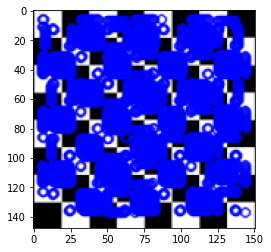

In [19]:
plt.imshow(image_with_keypoints)